# 解决手写数字识别的问题 - 数据处理

> #### ✔ 提前说明
>
> 为了将本文用于实训报告的书写，特将模块引入分散到了各代码块中，实际上这样做是坏文明

本篇文章只是对于该问题的一个简单处理和对代码的基本解释，集合度更高的在另一篇[NoteBook](./train.ipynb)中。


## 1、数据的读取与处理

In [39]:
import pandas as pd

train_csv = pd.read_csv("./data/train.csv")
# 提取训练集
train_label = train_csv['label']
train_data = train_csv.drop(labels=["label"], axis=1)
# 归一化
train_data = train_data/255
# 图像重塑
train_data = train_data.values.reshape(-1, 28, 28, 1)

# 比赛数据集
test_csv = pd.read_csv("./data/test.csv")
test_data = test_csv/255
test_data = test_data.values.reshape(-1, 28, 28, 1)

## 2、展示图片

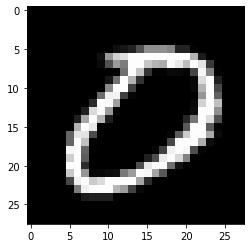

In [40]:
from matplotlib import pyplot as plt

plt.imshow(train_data[114],cmap="gray")

## 3、对数据进一步的处理

In [41]:
print("训练用数据集的大小：{}".format(train_data.shape))
print("待验证数据集的大小：{}".format(test_data.shape))

训练用数据集的大小：(42000, 28, 28, 1)
待验证数据集的大小：(28000, 28, 28, 1)


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

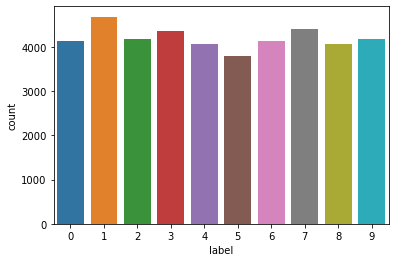

In [42]:
import seaborn as sns

sns.countplot(train_label)

In [43]:
print("Train Data Describe\n",train_csv.isnull().any().describe())
print("\nTest Data Describe\n",test_csv.isnull().any().describe())

Train Data Describe
 count       785
unique        1
top       False
freq        785
dtype: object

Test Data Describe
 count       784
unique        1
top       False
freq        784
dtype: object


In [44]:
from torch import nn
import torch

train_target = nn.functional.one_hot(torch.tensor(train_label)) # 独热编码
train_target

tensor([[0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

## 4、划分训练集和测试集

In [45]:
from torch.utils.data import Dataset
from torchvision import transforms

class TrainDataset(Dataset):
    # 创建训练数据集
    def __init__(self, path: str, train: bool = True, transform=None) -> None:
        data_csv = pd.read_csv(path)
        self.transform = transform                     # 对于数据集输出统一执行的Transform指令
        self.train = train                             # 判断当前是训练集和测试集的flag
        self.label = data_csv['label']                 # 提取label
        data = data_csv.drop(labels=["label"], axis=1) # 提取训练集
        data = data/255                                # 归一化
        self.data = data.values.reshape(-1, 28, 28, 1) # 图像重塑
        self.target = nn.functional.one_hot(torch.tensor(self.label))/1 # 目标值向量化(独热编码)
        self.total = len(self.label) # 训练用数据集的总大小
        self.cut = int(self.total/4) # 产生一个用于分割训练用数据集的指针
        super().__init__()

    def __len__(self) -> int:       # 重写了对于长度判断的逻辑
        if not self.train:          # 当类处于测试集状态下输出测试集的长度
            return self.cut
        return self.total-self.cut  # 训练集状态下输出减去的长度

    def __getitem__(self, index: int):
        if not self.train:          # 测试集从后往前输出，训练集正常输出
            index = self.total-index-1
        image = self.data[index]
        label = self.label[index]
        target = self.target[index]
        if self.transform:
            image = self.transform(image)
        return {'image': image,
                'label': label,
                'target': target}
        
example_dataset = TrainDataset(
    path="./data/train.csv",
    train= True,
    transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((28, 28)),
    ]))

## 5、数据加载器

In [46]:
from torch.utils.data import DataLoader

test_loader = DataLoader(
    TrainDataset(
        path="./data/train.csv",
        train=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((28, 28)),
        ]),
    ),
    batch_size=8*8,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

train_loader = DataLoader(
    TrainDataset(
        path="./data/train.csv",
        train=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((28, 28)),
        ]),
    ),
    batch_size=8*8,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

## 6、创建模型

In [47]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1,32,5,padding=2),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(32,64,5,padding=2),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            
            nn.Flatten(),
            nn.Linear(7*7*64,1000),
            nn.ReLU(),
            nn.Linear(1000,10),
            nn.Softmax(1),
        )

    def forward(self, x):
        x=x.to(torch.float32)
        x = self.model(x)
        return x

## 7、损失函数与优化器

In [49]:
from torch import optim

# 参数设置
learning_rate = 0.1             # 学习率
module_file_name = "./module-p.pth" # 模型存储
# GPU加速
t_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(t_device)
# 损失函数
loss = nn.CrossEntropyLoss().to(t_device)
# 优化器
opti = optim.SGD(model.parameters(), lr=learning_rate)
# 尝试加载本地模型
model.load_state_dict(torch.load(module_file_name))

## 8、模型训练和训练过程优化

In [50]:
for epoch in range(10):
    step = 0
    step_test = 0
    # 每一轮的统计数据
    loss_epoch = 0.0
    loss_epoch_test = 0.0
    total_accuracy = 0.0
    
    # 训练中
    model.train()
    for i_batch,batch_data in enumerate(train_loader):
        image = batch_data['image'].to(t_device)
        target = batch_data['target'].to(t_device)
        if step % 10 == 0:
            print("|", end="")
        opti.zero_grad() # 优化器置零
        output = model(image)
        result_loss = loss(output, target)
        result_loss.backward()
        opti.step()
        loss_epoch += result_loss
        step += 1
        
    # 模型验证过程
    model.eval()
    with torch.no_grad():
        for i_batch,batch_data in enumerate(test_loader):
            image = batch_data['image'].to(t_device)
            target = batch_data['target'].to(t_device)
            label = batch_data['label'].to(t_device)
            if step_test % 10 == 0:
                print("¦", end="")

            output = model(image)
            result_loss = loss(output, target)

            accuracy = (output.argmax(1) == label).sum()
            total_accuracy += accuracy
            loss_epoch_test += result_loss
            step_test += 1

    print("\nepoch:", epoch+1, "loss(total,train):%.2f" % loss_epoch,
          "loss(total,test):%.2f" % loss_epoch_test,
          "accuacry(test):%.2f" % (total_accuracy/(len(test_loader)*64)))

torch.save(model.state_dict(), module_file_name) # 存储训练的模型参数

||||||||||||||||||||||||||||||||||||||||||||||||||¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦
epoch: 1 loss(total,train):939.40 loss(total,test):271.57 accuacry(test):0.82
||||||||||||||||||||||||||||||||||||||||||||||||||¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦
epoch: 2 loss(total,train):782.94 loss(total,test):252.17 accuacry(test):0.93
||||||||||||||||||||||||||||||||||||||||||||||||||¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦
epoch: 3 loss(total,train):752.92 loss(total,test):253.23 accuacry(test):0.93
||||||||||||||||||||||||||||||||||||||||||||||||||¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦
epoch: 4 loss(total,train):744.36 loss(total,test):248.68 accuacry(test):0.95
||||||||||||||||||||||||||||||||||||||||||||||||||¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦
epoch: 5 loss(total,train):739.76 loss(total,test):246.87 accuacry(test):0.96
||||||||||||||||||||||||||||||||||||||||||||||||||¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦
epoch: 6 loss(total,train):736.43 loss(total,test):250.89 accuacry(test):0.94
||||||||||||||||||||||||||||||||||||||||||||||||||¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦
epoch: 7 loss(total,train):734.55 loss(total,test):245.0

## 9、提交文件

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
])

idx = []
ans = []

for index, image in enumerate(test_data):
    image = transform(image)
    image = torch.reshape(image, (1, 1, 28, 28))
    model.eval()
    with torch.no_grad():
        output = model(image)
        target = int(output.argmax(1))
        idx.append(index+1)
        ans.append(target)
        
frame = pd.DataFrame({'ImageId':idx,'Label':ans})
frame.to_csv("./submission.csv",index=False,sep=',')

## 10、数据增强和模型优化

这部分我不是很有时间弄，距离提交仅剩半个小时，大概抄下思路

已下代码均不可运行，我还没来得及整理和重写。

In [ ]:
# 通过数据增强来防止过拟合
datagen = ImageDataGenerator(
        featurewise_center=False,  # 对输入的图片每个通道减去每个通道对应均值
        samplewise_center=False,  # 每张图片减去样本均值, 使得每个样本均值为0
        featurewise_std_normalization=False,  # 将输入除以数据集的标准差
        samplewise_std_normalization=False,  # 将样本输入除以数据集的标准差
        zca_whitening=False,  # 去除样本之间的相关性
        rotation_range=10,  # 随机旋转图像（0到180度） 
        zoom_range = 0.1, # 随机缩放图像
        width_shift_range=0.1,   # 水平随机移动图像（总宽度的一部分）
        height_shift_range=0.1,  # 垂直随机移动图像（总高度的一部分）
        horizontal_flip=False,  # 水平随机翻转图像
        vertical_flip=False)  # 垂直随机翻转图像

datagen.fit(X_train)

In [ ]:
# 定义自己的混淆矩阵函数
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# 绘制混淆矩阵
Y_pred = model.predict(X_val)    # 对验证数据集进行预测
Y_pred_classes = np.argmax(Y_pred, axis=1)  # 将预测的类转换为一个热向量
Y_true = np.argmax(Y_val, axis=1)  # 将验证集中实际观察到的类转换为一个热向量
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)  # 计算混淆矩阵

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_confusion_matrix(confusion_mtx, classes=range(10))
plt.subplot(122)
plot_confusion_matrix(confusion_mtx, classes=range(10), normalize=True)